In [1]:
import glob
import os
import json
import pickle
import yaml

import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None
import pyarrow.parquet as pq
from sklearn.metrics import auc, roc_curve
from scipy.special import softmax

import hist as hist2
import matplotlib.pyplot as plt
import mplhep as hep

plt.style.use(hep.style.CMS)

import matplotlib.pyplot as plt
import mplhep as hep
from hist.intervals import clopper_pearson_interval
def get_yerr(num,den):
    return abs(clopper_pearson_interval(num.view(), den.view()) - num.view()/den.view())

import utils_farouk as utils
plt.rcParams.update({"font.size": 20})

/opt/anaconda3/envs/coffea-env/lib/python3.8/site-packages/pandas/core/computation/expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


In [2]:
%load_ext autoreload
%autoreload 2

# Electron trigger scale factors

In [125]:
import correctionlib

filename = f"../boostedhiggs/data/electron_trigger_2017_UL.json"
ceval = correctionlib.CorrectionSet.from_file(filename)
list(ceval.keys())

['UL-Electron-Trigger-SF']

In [126]:
for corr in ceval.values():
    print(f"Correction {corr.name} has {len(corr.inputs)} inputs")
    for ix in corr.inputs:
        print(f"   Input {ix.name} ({ix.type}): {ix.description}")

Correction UL-Electron-Trigger-SF has 2 inputs
   Input eta (real): 
   Input pt (real): 


In [127]:
# testing the evaluate method given a pt=10 and an eta=1
sf = ceval["UL-Electron-Trigger-SF"].evaluate(1., 10.)
sf

0.3009999990463257

In [140]:
# generate 100k samples
size = 100000
ptvals = np.random.uniform(low=35, high=350, size=size)
etavals = np.random.uniform(low=-2.4, high=2.4, size=size)

sf = ceval["UL-Electron-Trigger-SF"].evaluate(etavals, ptvals)
sf.shape

(100000,)

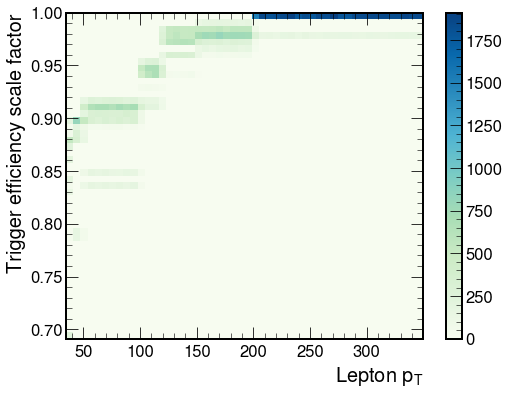

In [133]:
plt.style.use(hep.style.CMS)
plt.rcParams.update({"font.size": 20})

x = ptvals
y = sf

fig, ax = plt.subplots(figsize=(8,6))
plt.hist2d(x,y, 50, cmap='GnBu')

ax.set_xlabel(r"Lepton $p_T$")
ax.set_ylabel(r"Trigger efficiency scale factor")

plt.colorbar()

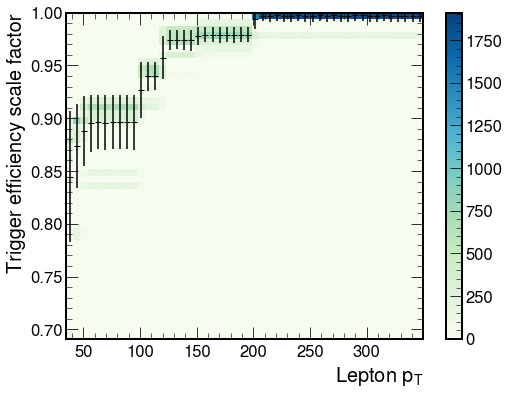

In [135]:
# add uncertainties

fig, ax = plt.subplots(figsize=(8,6))
h, xe, ye, im = plt.hist2d(x,y, 50, cmap='GnBu')

# bin width
xbinw = xe[1]-xe[0]

# getting the mean and RMS values of each vertical slice of the 2D distribution
x_slice_mean, x_slice_rms = [], []
for i,b in enumerate(xe[:-1]):
    x_slice_mean.append( y[ (x>xe[i]) & (x<=xe[i+1]) ].mean())
    x_slice_rms.append( y[ (x>xe[i]) & (x<=xe[i+1]) ].std())
    
x_slice_mean = np.array(x_slice_mean)
x_slice_rms = np.array(x_slice_rms)
    
plt.errorbar(xe[:-1]+ xbinw/2, x_slice_mean, x_slice_rms,fmt='_', ecolor='k', color='k')

plt.colorbar()

ax.set_xlabel(r"Lepton $p_T$")
ax.set_ylabel(r"Trigger efficiency scale factor")

plt.show()

In [131]:
def compute_profile(x, y, nbin=(100,100)):
    
    # use of the 2d hist by numpy to avoid plotting
    h, xe, ye = np.histogram2d(x,y,nbin)
    
    # bin width
    xbinw = xe[1]-xe[0]

    # getting the mean and RMS values of each vertical slice of the 2D distribution
    # also the x valuse should be recomputed because of the possibility of empty slices
    x_array      = []
    x_slice_mean = []
    x_slice_rms  = []
    for i in range(xe.size-1):
        yvals = y[ (x>xe[i]) & (x<=xe[i+1]) ]
        if yvals.size>0: # do not fill the quanties for empty slices
            x_array.append(xe[i]+ xbinw/2)
            x_slice_mean.append( yvals.mean())
            x_slice_rms.append( yvals.std())
    x_array = np.array(x_array)
    x_slice_mean = np.array(x_slice_mean)
    x_slice_rms = np.array(x_slice_rms)

    return x_array, x_slice_mean, x_slice_rms

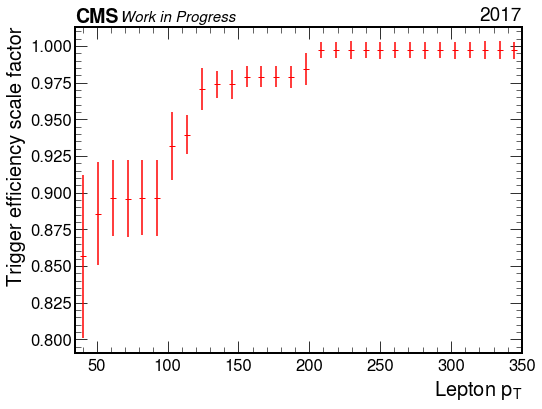

In [132]:
#compute the profile
plt.style.use(hep.style.CMS)
plt.rcParams.update({"font.size": 20})

fig, ax = plt.subplots(figsize=(8,6))

p_x, p_mean, p_rms = compute_profile(x,y,(30,30))

plt.errorbar(p_x, p_mean, p_rms,fmt='_', ecolor='r', color='r')
ax.set_xlim(35,350)
# ax.set_ylim(0, 1)
ax.set_xlabel(r"Lepton $p_T$")
ax.set_ylabel(r"Trigger efficiency scale factor")

hep.cms.lumitext(
    "2017", ax=ax, fontsize=20
)
hep.cms.text("Work in Progress", ax=ax, fontsize=15)

plt.savefig("/Users/fmokhtar/Desktop/trigger_eff_scale_factor.pdf")

plt.show()

# 2d plot

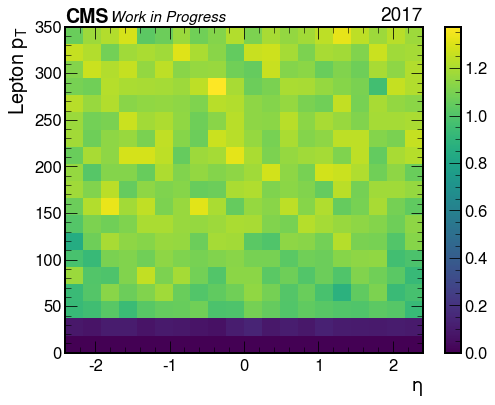

In [107]:
import math
import matplotlib
import matplotlib.pyplot as plt
import mplhep as hep
import matplotlib.colors as colors

plt.style.use(hep.style.CMS)
plt.rcParams.update({"font.size": 20})

fig, ax = plt.subplots(figsize=(8,6))

xbins = 20
ybins = 20
nbins = xbins * ybins

plt.hist2d(etavals, ptvals, bins=[xbins, np.linspace(0,350,ybins)], weights=sf*nbins/size);
ax.set_xlabel(r"$\eta$")
ax.set_ylabel(r"Lepton $p_T$")

hep.cms.lumitext(
    "2017", ax=ax, fontsize=20
)
hep.cms.text("Work in Progress", ax=ax, fontsize=15)

plt.colorbar()

# Electron ID scale factors

In [183]:
import correctionlib

filename = f"../boostedhiggs/data/UL-Electron-ID-SF_2017.json"
ceval = correctionlib.CorrectionSet.from_file(filename)
list(ceval.keys())

['UL-Electron-ID-SF']

In [184]:
for corr in ceval.values():
    print(f"Correction {corr.name} has {len(corr.inputs)} inputs")
    for ix in corr.inputs:
        print(f"   Input {ix.name} ({ix.type}): {ix.description}")

Correction UL-Electron-ID-SF has 5 inputs
   Input year (string): year/scenario: example 2016preVFP, 2017 etc
   Input ValType (string): sf/sfup/sfdown (sfup = sf + syst, sfdown = sf - syst) 
   Input WorkingPoint (string): Working Point of choice : Loose, Medium etc.
   Input eta (real): supercluster eta
   Input pt (real): electron pT


In [187]:
# testing the evaluate method given a pt=10 and an eta=1
sf = ceval["UL-Electron-ID-SF"].evaluate("2017", "sf", "Medium", 1., 10.)
sf

1.0055969953536987

In [198]:
# generate 10k samples
size = 100000
ptvals = np.random.uniform(low=10, high=350, size=size)
etavals = np.random.uniform(low=-2.4, high=2.4, size=size)

sf = ceval["UL-Electron-ID-SF"].evaluate("2017", "sf", "Medium", etavals, ptvals)
sf.shape

(100000,)

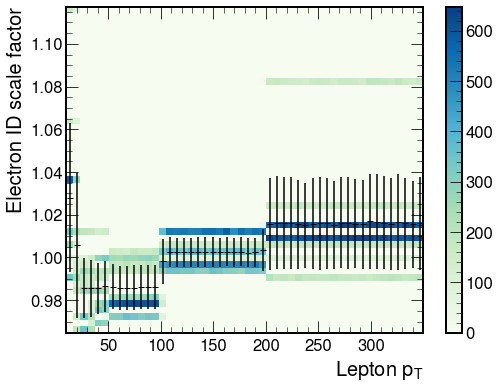

In [200]:
x = ptvals
y = sf

fig, ax = plt.subplots(figsize=(8,6))
h, xe, ye, im = plt.hist2d(x,y, 50, cmap='GnBu')

# bin width
xbinw = xe[1]-xe[0]

# getting the mean and RMS values of each vertical slice of the 2D distribution
x_slice_mean, x_slice_rms = [], []
for i,b in enumerate(xe[:-1]):
    x_slice_mean.append( y[ (x>xe[i]) & (x<=xe[i+1]) ].mean())
    x_slice_rms.append( y[ (x>xe[i]) & (x<=xe[i+1]) ].std())
    
x_slice_mean = np.array(x_slice_mean)
x_slice_rms = np.array(x_slice_rms)
    
plt.errorbar(xe[:-1]+ xbinw/2, x_slice_mean, x_slice_rms,fmt='_', ecolor='k', color='k')

plt.colorbar()

ax.set_xlabel(r"Lepton $p_T$")
ax.set_ylabel(r"Electron ID efficiency scale factor")

plt.show()

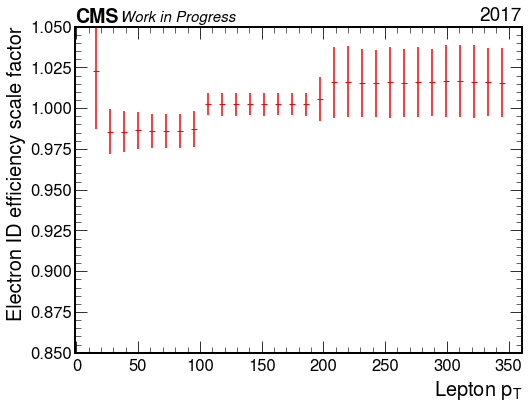

In [205]:
#compute the profile
plt.style.use(hep.style.CMS)
plt.rcParams.update({"font.size": 20})

x = ptvals
y = sf

fig, ax = plt.subplots(figsize=(8,6))

p_x, p_mean, p_rms = compute_profile(x,y,(30,30))

plt.errorbar(p_x, p_mean, p_rms,fmt='_', ecolor='r', color='r')
# ax.set_xlim(35,350)
ax.set_ylim(0.85, 1.05)
ax.set_xlabel(r"Lepton $p_T$")
ax.set_ylabel(r"Electron ID efficiency scale factor")

hep.cms.lumitext(
    "2017", ax=ax, fontsize=20
)
hep.cms.text("Work in Progress", ax=ax, fontsize=15)

# plt.savefig("/Users/fmokhtar/Desktop/trigger_eff_scale_factor.pdf")

plt.show()

# Muon trigger scale factors

In [210]:
# recall our muon triggers
lepton_corrections = {
    "trigger_iso": {
        "muon": {  # For IsoMu24 (| IsoTkMu24 )
            "2016APV": "NUM_IsoMu24_or_IsoTkMu24_DEN_CutBasedIdTight_and_PFIsoTight",  # preVBP
            "2016": "NUM_IsoMu24_or_IsoTkMu24_DEN_CutBasedIdTight_and_PFIsoTight",  # postVBF
            "2017": "NUM_IsoMu27_DEN_CutBasedIdTight_and_PFIsoTight",
            "2018": "NUM_IsoMu24_DEN_CutBasedIdTight_and_PFIsoTight",
        },
    },
    "trigger_noniso": {
        "muon": {  # For Mu50 (| TkMu50 )
            "2016APV": "NUM_Mu50_or_TkMu50_DEN_CutBasedIdGlobalHighPt_and_TkIsoLoose",
            "2016": "NUM_Mu50_or_TkMu50_DEN_CutBasedIdGlobalHighPt_and_TkIsoLoose",
            "2017": "NUM_Mu50_or_OldMu100_or_TkMu100_DEN_CutBasedIdGlobalHighPt_and_TkIsoLoose",
            "2018": "NUM_Mu50_or_OldMu100_or_TkMu100_DEN_CutBasedIdGlobalHighPt_and_TkIsoLoose",
        },
    },
}

In [206]:
import correctionlib

filename = f"../boostedhiggs/data/Efficiencies_muon_generalTracks_Z_Run2017_UL_SingleMuonTriggers_schemaV2.json"
ceval = correctionlib.CorrectionSet.from_file(filename)
list(ceval.keys())

['NUM_IsoMu27_DEN_CutBasedIdMedium_and_PFIsoMedium',
 'NUM_IsoMu27_DEN_CutBasedIdTight_and_PFIsoTight',
 'NUM_IsoMu27_or_Mu50_DEN_CutBasedIdMedium_and_PFIsoMedium',
 'NUM_IsoMu27_or_Mu50_DEN_CutBasedIdTight_and_PFIsoTight',
 'NUM_Mu50_or_OldMu100_or_TkMu100_DEN_CutBasedIdGlobalHighPt_and_TkIsoLoose']

In [207]:
for corr in ceval.values():
    print(f"Correction {corr.name} has {len(corr.inputs)} inputs")
    for ix in corr.inputs:
        print(f"   Input {ix.name} ({ix.type}): {ix.description}")

Correction NUM_IsoMu27_DEN_CutBasedIdMedium_and_PFIsoMedium has 3 inputs
   Input eta (real): Probe eta
   Input pt (real): Probe pt
   Input scale_factors (string): Choose nominal scale factor or one of the uncertainties
Correction NUM_IsoMu27_DEN_CutBasedIdTight_and_PFIsoTight has 3 inputs
   Input eta (real): Probe eta
   Input pt (real): Probe pt
   Input scale_factors (string): Choose nominal scale factor or one of the uncertainties
Correction NUM_IsoMu27_or_Mu50_DEN_CutBasedIdMedium_and_PFIsoMedium has 3 inputs
   Input eta (real): Probe eta
   Input pt (real): Probe pt
   Input scale_factors (string): Choose nominal scale factor or one of the uncertainties
Correction NUM_IsoMu27_or_Mu50_DEN_CutBasedIdTight_and_PFIsoTight has 3 inputs
   Input eta (real): Probe eta
   Input pt (real): Probe pt
   Input scale_factors (string): Choose nominal scale factor or one of the uncertainties
Correction NUM_Mu50_or_OldMu100_or_TkMu100_DEN_CutBasedIdGlobalHighPt_and_TkIsoLoose has 3 inputs
  

In [212]:
# testing the evaluate method given a pt=100 and an eta=1
sf = ceval["NUM_IsoMu27_DEN_CutBasedIdTight_and_PFIsoTight"].evaluate(1.0, 55.0, "nominal")
sf

0.949164300184991

In [211]:
# testing the evaluate method given a pt=100 and an eta=1
sf = ceval["NUM_Mu50_or_OldMu100_or_TkMu100_DEN_CutBasedIdGlobalHighPt_and_TkIsoLoose"].evaluate(1.0, 55.0, "nominal")
sf

0.9417989537511458

In [226]:
# generate 10k samples
size = 100000
ptvals = np.random.uniform(low=55, high=200, size=size)
etavals = np.random.uniform(low=-2.4, high=2.4, size=size)

sf1 = ceval["NUM_IsoMu27_DEN_CutBasedIdTight_and_PFIsoTight"].evaluate(etavals, ptvals, "nominal")
sf2 = ceval["NUM_Mu50_or_OldMu100_or_TkMu100_DEN_CutBasedIdGlobalHighPt_and_TkIsoLoose"].evaluate(etavals, ptvals, "nominal")

sf = sf1*sf2

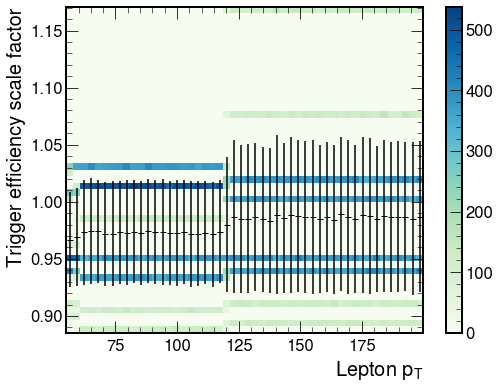

In [214]:
x = ptvals
y = sf

fig, ax = plt.subplots(figsize=(8,6))
h, xe, ye, im = plt.hist2d(x,y, 50, cmap='GnBu')

# bin width
xbinw = xe[1]-xe[0]

# getting the mean and RMS values of each vertical slice of the 2D distribution
x_slice_mean, x_slice_rms = [], []
for i,b in enumerate(xe[:-1]):
    x_slice_mean.append( y[ (x>xe[i]) & (x<=xe[i+1]) ].mean())
    x_slice_rms.append( y[ (x>xe[i]) & (x<=xe[i+1]) ].std())
    
x_slice_mean = np.array(x_slice_mean)
x_slice_rms = np.array(x_slice_rms)
    
plt.errorbar(xe[:-1]+ xbinw/2, x_slice_mean, x_slice_rms,fmt='_', ecolor='k', color='k')

plt.colorbar()

ax.set_xlabel(r"Lepton $p_T$")
ax.set_ylabel(r"Trigger efficiency scale factor")

plt.show()

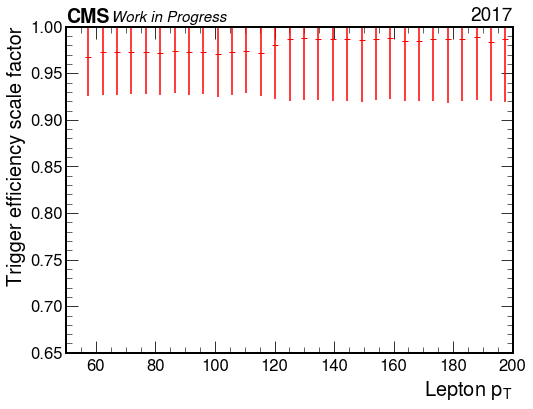

In [227]:
#compute the profile
plt.style.use(hep.style.CMS)
plt.rcParams.update({"font.size": 20})

x = ptvals
y = sf

fig, ax = plt.subplots(figsize=(8,6))

p_x, p_mean, p_rms = compute_profile(x,y,(30,30))

plt.errorbar(p_x, p_mean, p_rms,fmt='_', ecolor='r', color='r')
ax.set_xlim(50,200)
ax.set_ylim(0.65, 1)
ax.set_xlabel(r"Lepton $p_T$")
ax.set_ylabel(r"Trigger efficiency scale factor")

hep.cms.lumitext(
    "2017", ax=ax, fontsize=20
)
hep.cms.text("Work in Progress", ax=ax, fontsize=15)

plt.savefig("/Users/fmokhtar/Desktop/trigger_eff_scale_factor.pdf")

plt.show()